# **Electric Vehicle Population Data Visualization**

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns 
import sqlite3 as sqlite
from scipy import stats
import geopandas as gpd

import warnings
warnings.simplefilter(action='ignore', 
                      category=UserWarning
                      )

connection = sqlite.connect('washington_electric_vehicle_population.db')
connection

# viz customizations
params = {
    "lines.linewidth": 1.5,
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "axes.spines.right": False,
    "axes.spines.top": False,
}
sns.set_theme(context = 'paper', 
              style='white', 
              palette='deep', 
              rc=params
              )
plt.rcParams['font.family']='Times New Roman'
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (12,5)
pd.options.display.float_format = "{:,.2f}".format


In [33]:
evs_df = pd.read_csv(r'vehicles.csv')
history_df = pd.read_csv(r'history_data.csv', parse_dates=['date'])
location_df = pd.read_csv(r'location.csv')
counties = gpd.read_file(r'WA_County_Boundaries.zip')


In [34]:
evs_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177866 entries, 0 to 177865
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   dol_vehicle_id    177866 non-null  int64 
 1   make              177866 non-null  object
 2   model             177866 non-null  object
 3   model_year        177866 non-null  int64 
 4   ev_type           177866 non-null  object
 5   cafv_eligibility  177866 non-null  object
 6   range             177866 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 9.5+ MB


In [35]:
history_df


,date,phev_count,bev_count,ev_total_count,year
0,2024-02-29,38656,139210,177866,2024
1,2024-01-31,38166,136494,174660,2024
2,2023-12-31,37142,132362,169504,2023
3,2023-11-30,36533,129084,165617,2023
4,2023-10-31,35888,125977,161865,2023
...,...,...,...,...,...
81,2017-05-31,8498,16569,25067,2017
82,2017-04-30,8287,16104,24391,2017
83,2017-03-31,8093,15596,23689,2017
84,2017-02-28,7889,15206,23095,2017


In [36]:
location_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177866 entries, 0 to 177865
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   dol_vehicle_id  177866 non-null  int64  
 1   longitude       177857 non-null  float64
 2   latitude        177857 non-null  float64
 3   county          177861 non-null  object 
 4   city            177861 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 6.8+ MB


## **Tracking the expansion of electric vehicles and providing updates on the current total count of EVs in WA**

In [37]:

annual_sum = history_df.query('date.dt.month == 12')
annual_sum


,date,phev_count,bev_count,ev_total_count,year
2,2023-12-31,37142,132362,169504,2023
14,2022-12-31,28194,89845,118039,2022
26,2021-12-31,23557,64456,88013,2021
38,2020-12-31,18892,47340,66232,2020
50,2019-12-31,17130,37755,54885,2019
62,2018-12-31,14343,27722,42065,2018
74,2017-12-31,10121,19186,29307,2017


In [38]:
history_df = (annual_sum
              .rename(columns={'phev_count':'PHEV', 'bev_count':'BEV'})
              .melt(id_vars='year', value_vars=['PHEV','BEV'],
                    var_name='attribute', value_name='total')
              .set_index('year')
              )
history_df 


,attribute,total
year,,
2023,PHEV,37142
2022,PHEV,28194
2021,PHEV,23557
2020,PHEV,18892
2019,PHEV,17130
2018,PHEV,14343
2017,PHEV,10121
2023,BEV,132362
2022,BEV,89845


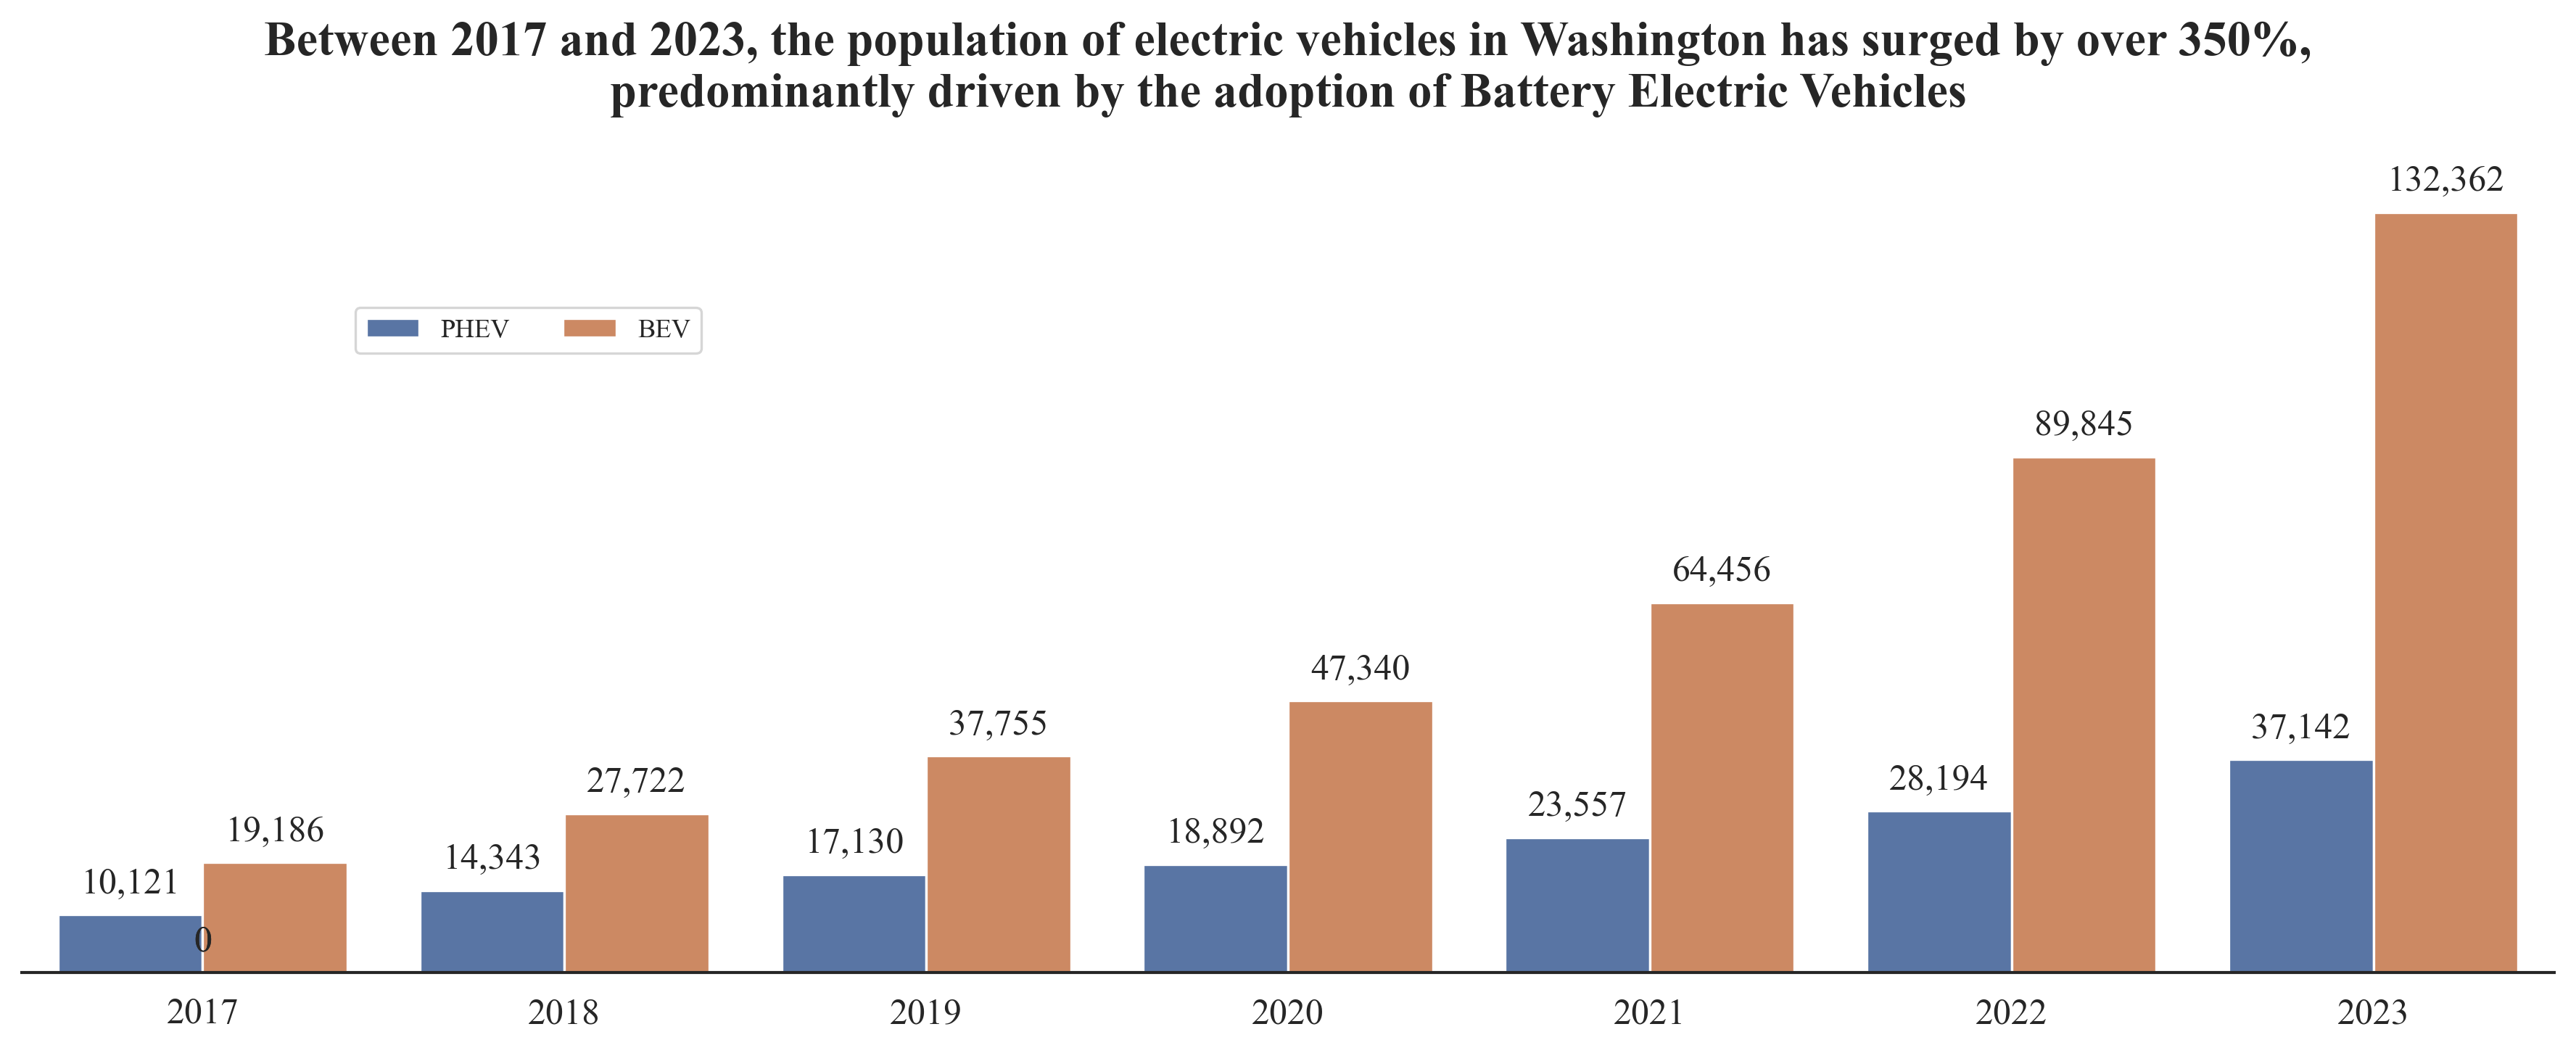

In [39]:
fig, ax = plt.subplots()
ax = sns.barplot(x=history_df.index, y='total', 
                 hue='attribute', data = history_df, 
                 errorbar=None)

for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), 
                textcoords='offset points')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Between 2017 and 2023, the population of electric vehicles in Washington has surged by over 350%,\n'\
             'predominantly driven by the adoption of Battery Electric Vehicles\n',
             loc='center', fontweight='bold')

plt.legend(bbox_to_anchor=(0.2, 0.85), 
           loc='upper center', ncol=2)
ax.spines['left'].set_visible(False)
ax.tick_params(left=False, labelleft=False)
plt.tight_layout();


In [40]:
total_electric_vehicles_query = """
    WITH total_distinct_vehicles AS (
        SELECT 
            DISTINCT dol_vehicle_id,
            ev_type
        FROM 
            vehicles
    ),
    total_electric_vehicles AS (
        SELECT
            SUM(CASE 
                    WHEN ev_type LIKE '%Battery%' THEN 1 ELSE 0 
                END) AS total_BEV,
            SUM(CASE
                    WHEN ev_type LIKE '%Plug-In%' THEN 1 ELSE 0 
                END) AS total_PHEV,
            COUNT(DISTINCT dol_vehicle_id) AS total_evs
        FROM
            total_distinct_vehicles
    )
    SELECT *
    FROM total_electric_vehicles
    """
total_electric_vehicles = pd.read_sql_query(total_electric_vehicles_query,connection)
total_electric_vehicles 


,total_BEV,total_PHEV,total_evs
0,139210,38656,177866


In [41]:
total_ev_summary = pd.DataFrame({'ev_type': ['BEV','PHEV'],
                                 'pct_total': [((139210*100)/177866),((38656*100)/177866)]
                                 }
                                ).set_index('ev_type')
total_ev_summary


,pct_total
ev_type,
BEV,78.27
PHEV,21.73


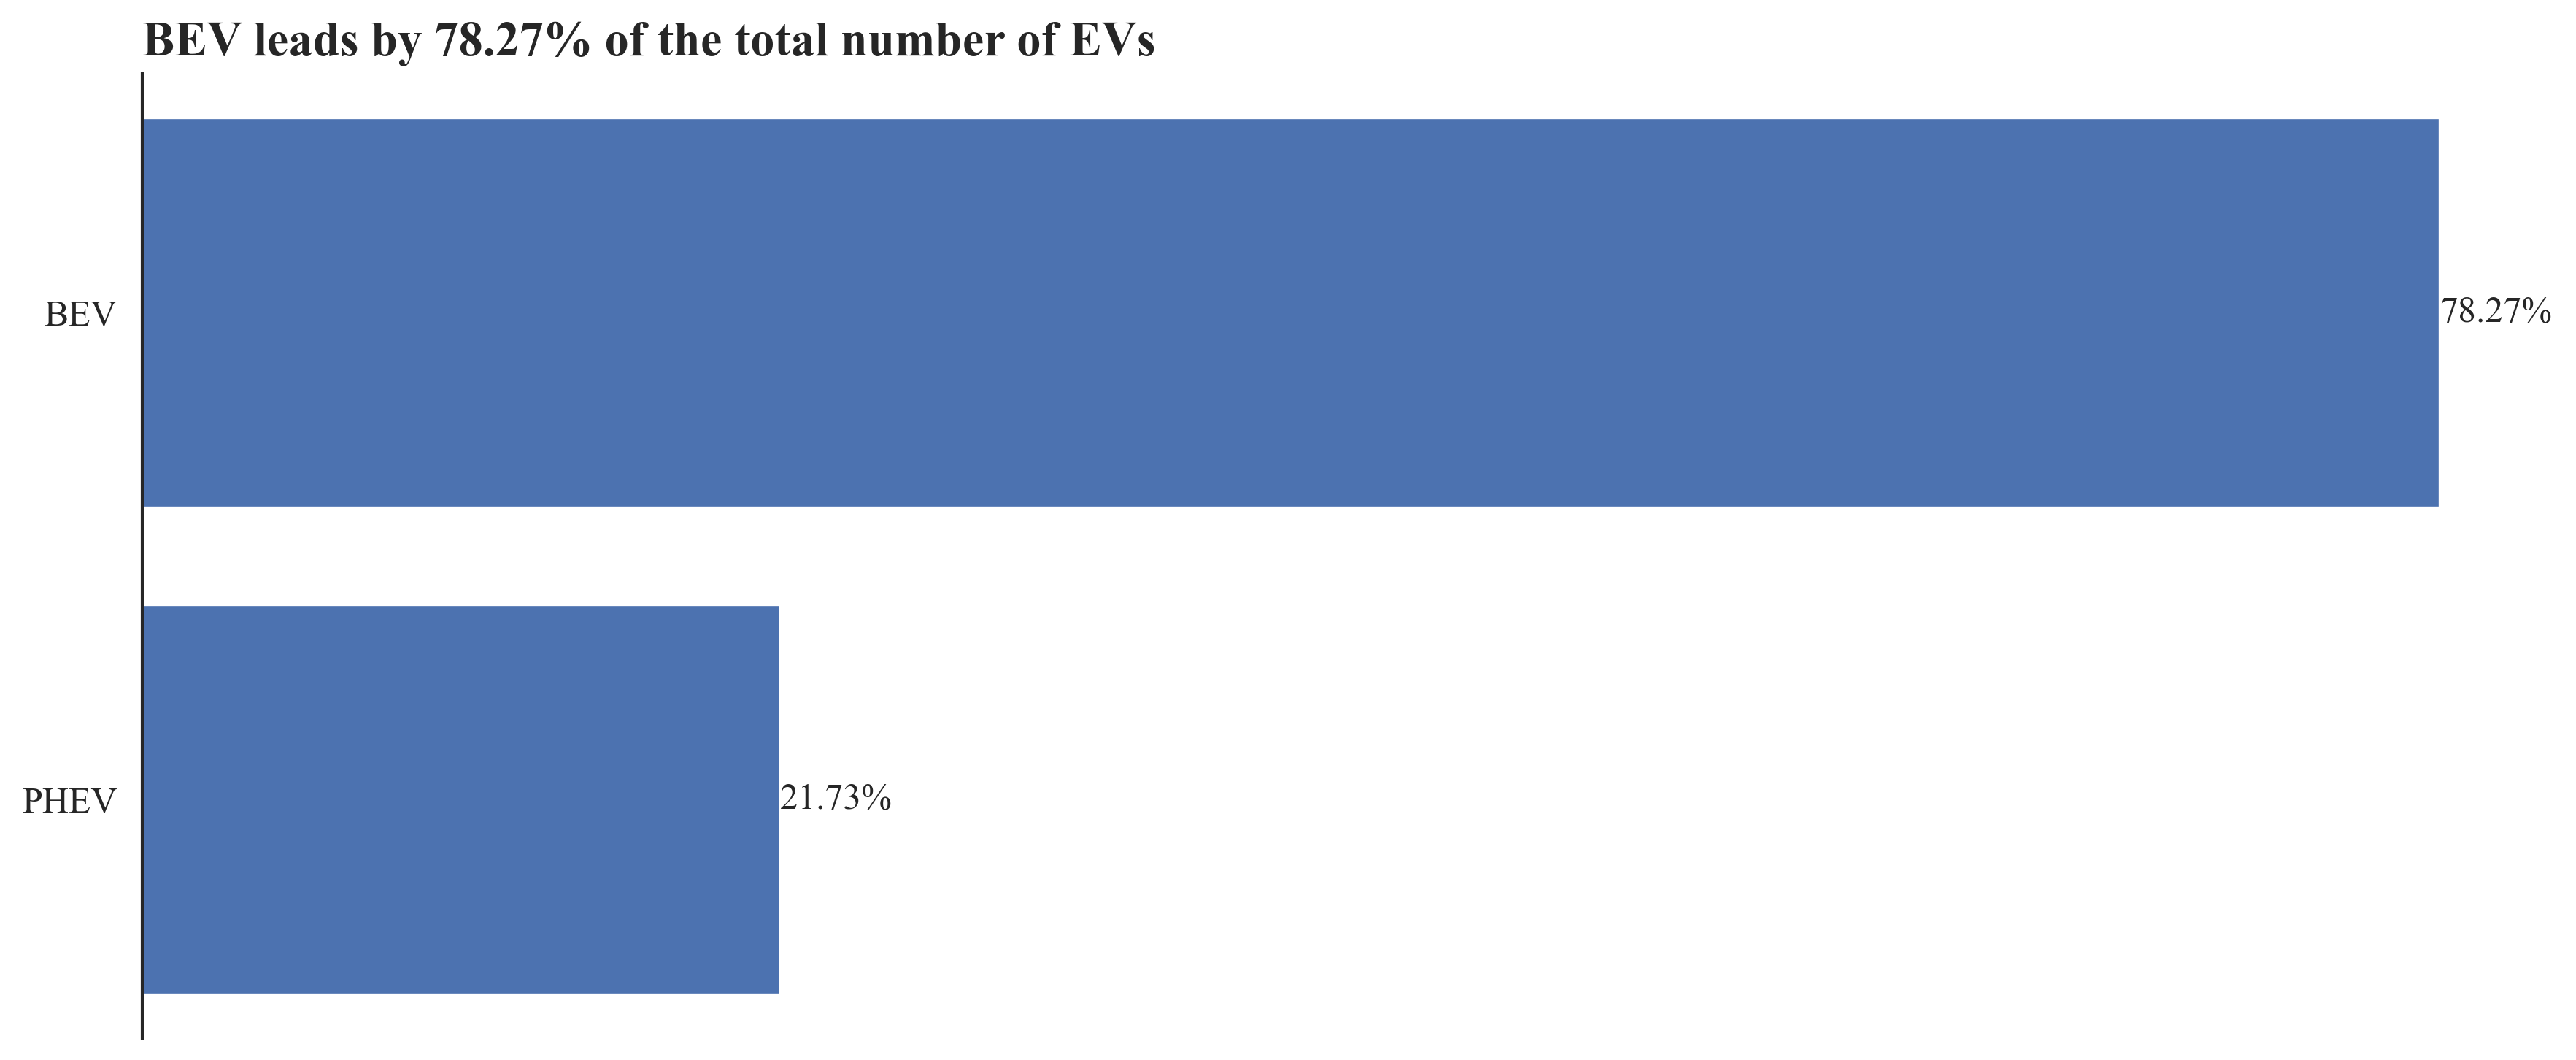

In [42]:
sorted_indices = sorted(range(len(total_ev_summary['pct_total'])), key=lambda i: total_ev_summary['pct_total'].iloc[i], reverse=False)
sorted_make = [total_ev_summary.index[i] for i in sorted_indices]
sorted_size = [total_ev_summary['pct_total'].iloc[i] for i in sorted_indices]

fig, ax = plt.subplots()

ax.barh(sorted_make, sorted_size)

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('BEV leads by 78.27% of the total number of EVs', 
                loc='left', fontweight='bold')
ax.spines['bottom'].set_visible(False)
ax.tick_params(bottom=False, labelbottom=False)

for i, volume in enumerate(sorted_size):
    ax.text(volume, i, f"{volume:,.2f}%", va="center", fontsize=12)
plt.tight_layout();


## **Which EV make is most popular among EVs in WA?**

In [43]:
make_summary_query = """ 
    WITH vehicle_types AS (
        SELECT 
            DISTINCT dol_vehicle_id,
            make,
            ev_type
        FROM 
            vehicles
        ),
        evs_per_make AS (
            SELECT
                make AS make,
                SUM(CASE 
                        WHEN ev_type LIKE '%Battery%' THEN 1 ELSE 0 
                    END) AS bev,
                SUM(CASE 
                        WHEN ev_type LIKE '%Plug-In%' THEN 1 ELSE 0 
                    END) AS phev,
                COUNT(DISTINCT dol_vehicle_id) AS total_evs
            FROM 
                vehicle_types
            GROUP BY
                make
        )
        SELECT 
            e_p_m.make,
            e_p_m.bev,
            e_p_m.phev
        FROM 
            evs_per_make AS e_p_m
           
"""
make_summary = pd.read_sql_query(make_summary_query, connection)
make_summary


,make,bev,phev
0,ALFA ROMEO,0,39
1,AUDI,2251,1395
2,AZURE DYNAMICS,8,0
3,BENTLEY,0,3
4,BMW,2515,5055
5,CADILLAC,290,92
6,CHEVROLET,8882,4796
7,CHRYSLER,0,2993
8,DODGE,0,568
9,FIAT,784,0


In [44]:
make_size = make_summary


In [45]:
total = make_size['bev'].sum() + make_size['phev'].sum()
make_size = make_size.assign(make =  make_size.make.str.title(),
                             pct_total = (lambda x: ((x.bev + x.phev) / total)*100)
                             ).sort_values('pct_total', ascending=False)
make_size


,make,bev,phev,pct_total
34,Tesla,79659,0,44.79
27,Nissan,13998,0,7.87
6,Chevrolet,8882,4796,7.69
11,Ford,5517,3682,5.17
4,Bmw,2515,5055,4.26
18,Kia,5039,2393,4.18
36,Toyota,336,5952,3.54
37,Volkswagen,5004,0,2.81
17,Jeep,0,4480,2.52
15,Hyundai,3775,631,2.48


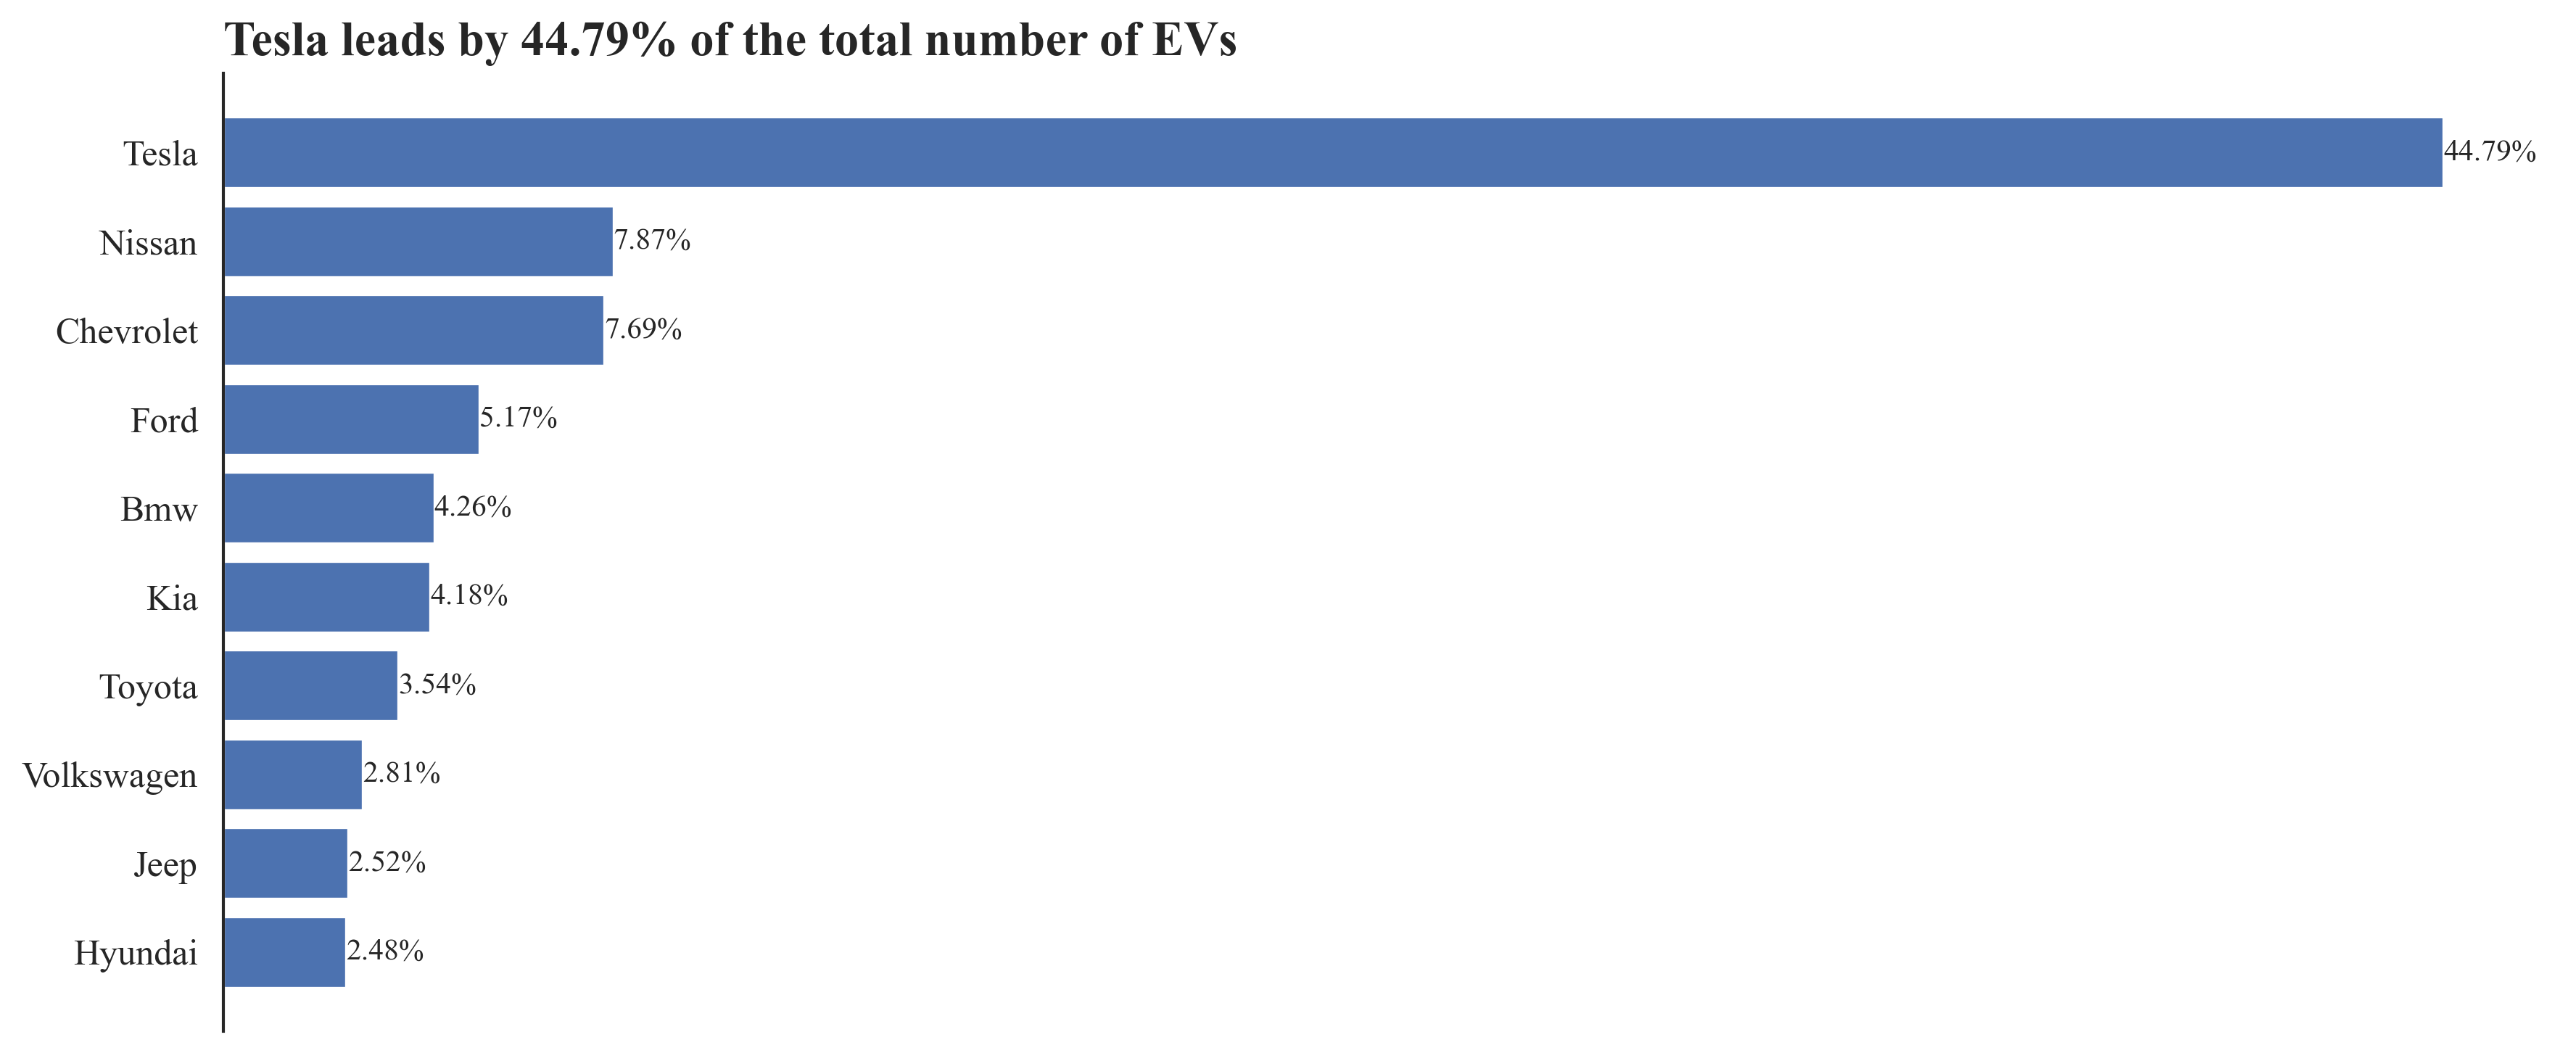

In [46]:
make_size_sorted = make_size.head(10).sort_values(by='pct_total', ascending=True)
fig, ax = plt.subplots()
ax.barh(make_size_sorted['make'], make_size_sorted['pct_total'])

ax.set_title('Tesla leads by 44.79% of the total number of EVs', loc='left', fontweight='bold')
ax.spines['bottom'].set_visible(False)
ax.tick_params(bottom=False, labelbottom=False)
for i, volume in enumerate(make_size_sorted['pct_total']):
    ax.text(volume, i, f"{volume:,.2f}%", va="center", fontsize=10)

plt.tight_layout();


In [47]:
bev_make_size = (make_size[['make','bev']]
                 .query('bev > 0')
                 .assign(bev_pct_total = (lambda x: (x.bev / x.bev.sum())*100))
                 .set_index('make')
                 )
bev_make_size


,bev,bev_pct_total
make,,
Tesla,79659,57.22
Nissan,13998,10.06
Chevrolet,8882,6.38
Ford,5517,3.96
Bmw,2515,1.81
Kia,5039,3.62
Toyota,336,0.24
Volkswagen,5004,3.59
Hyundai,3775,2.71


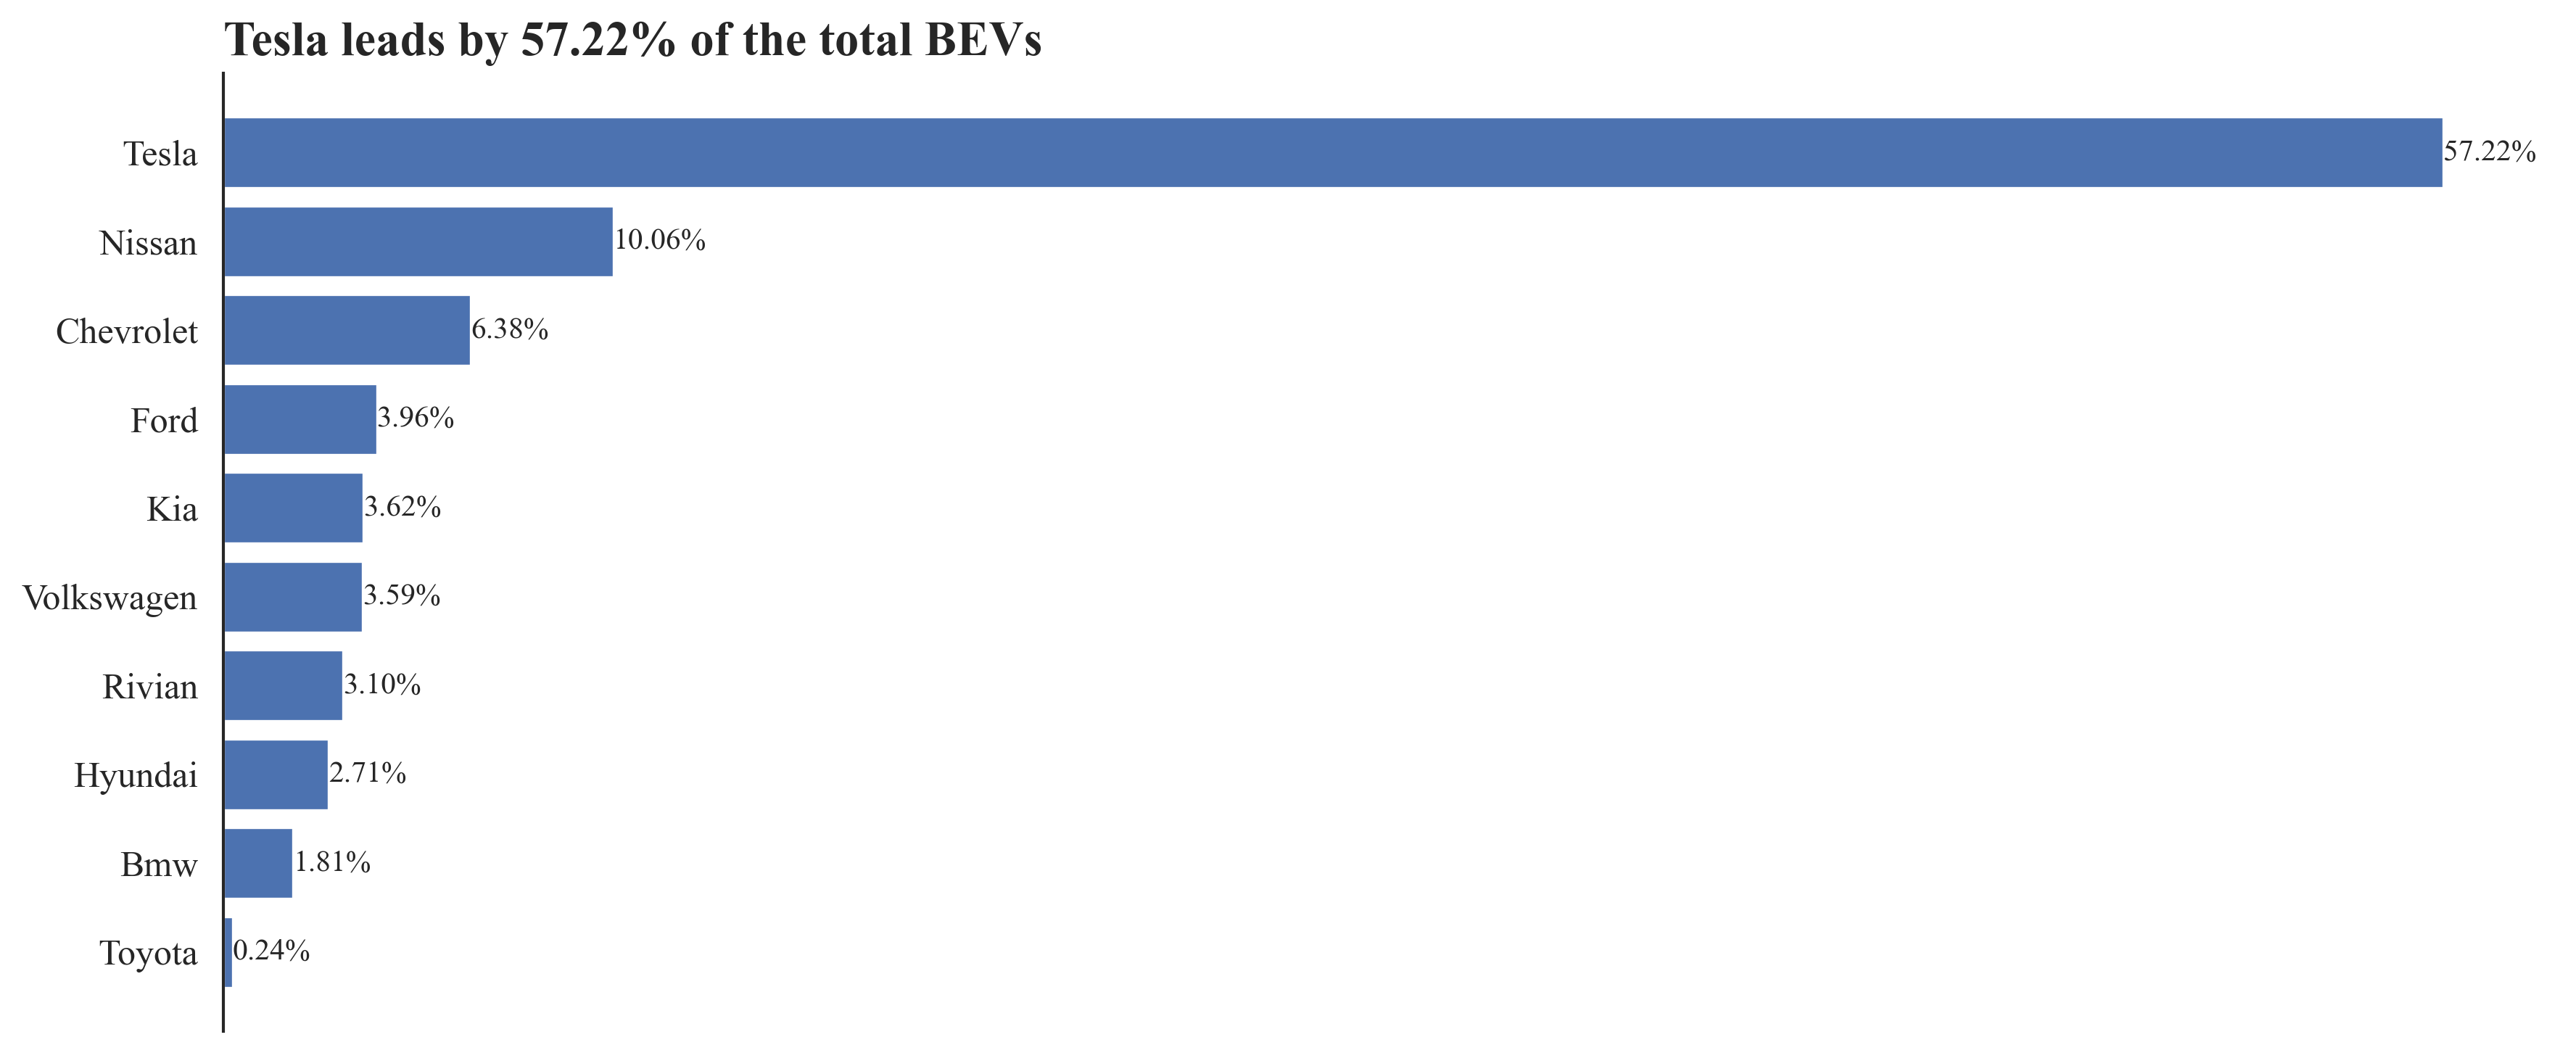

In [48]:
sorted_indices = sorted(range(len(bev_make_size['bev_pct_total'].head(10))), key=lambda i: bev_make_size['bev_pct_total'].iloc[i], reverse=False)
sorted_make = [bev_make_size.index[i] for i in sorted_indices]
sorted_size = [bev_make_size['bev_pct_total'].iloc[i] for i in sorted_indices]

fig, ax = plt.subplots()

ax.barh(sorted_make, sorted_size)

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Tesla leads by 57.22% of the total BEVs', 
                loc='left', fontweight='bold')
ax.spines['bottom'].set_visible(False)
ax.tick_params(bottom=False, labelbottom=False)

for i, volume in enumerate(sorted_size):
    ax.text(volume, i, f"{volume:,.2f}%", va="center", fontsize=10)
plt.tight_layout();


In [49]:
phev_make_size = (make_size[['make','phev']]
                 .query('phev > 0')
                 .assign(phev_pct_total = (lambda x: (x.phev / x.phev.sum())*100))
                 .set_index('make')
                 )
phev_make_size


,phev,phev_pct_total
make,,
Chevrolet,4796,12.41
Ford,3682,9.53
Bmw,5055,13.08
Kia,2393,6.19
Toyota,5952,15.40
Jeep,4480,11.59
Hyundai,631,1.63
Volvo,2711,7.01
Audi,1395,3.61


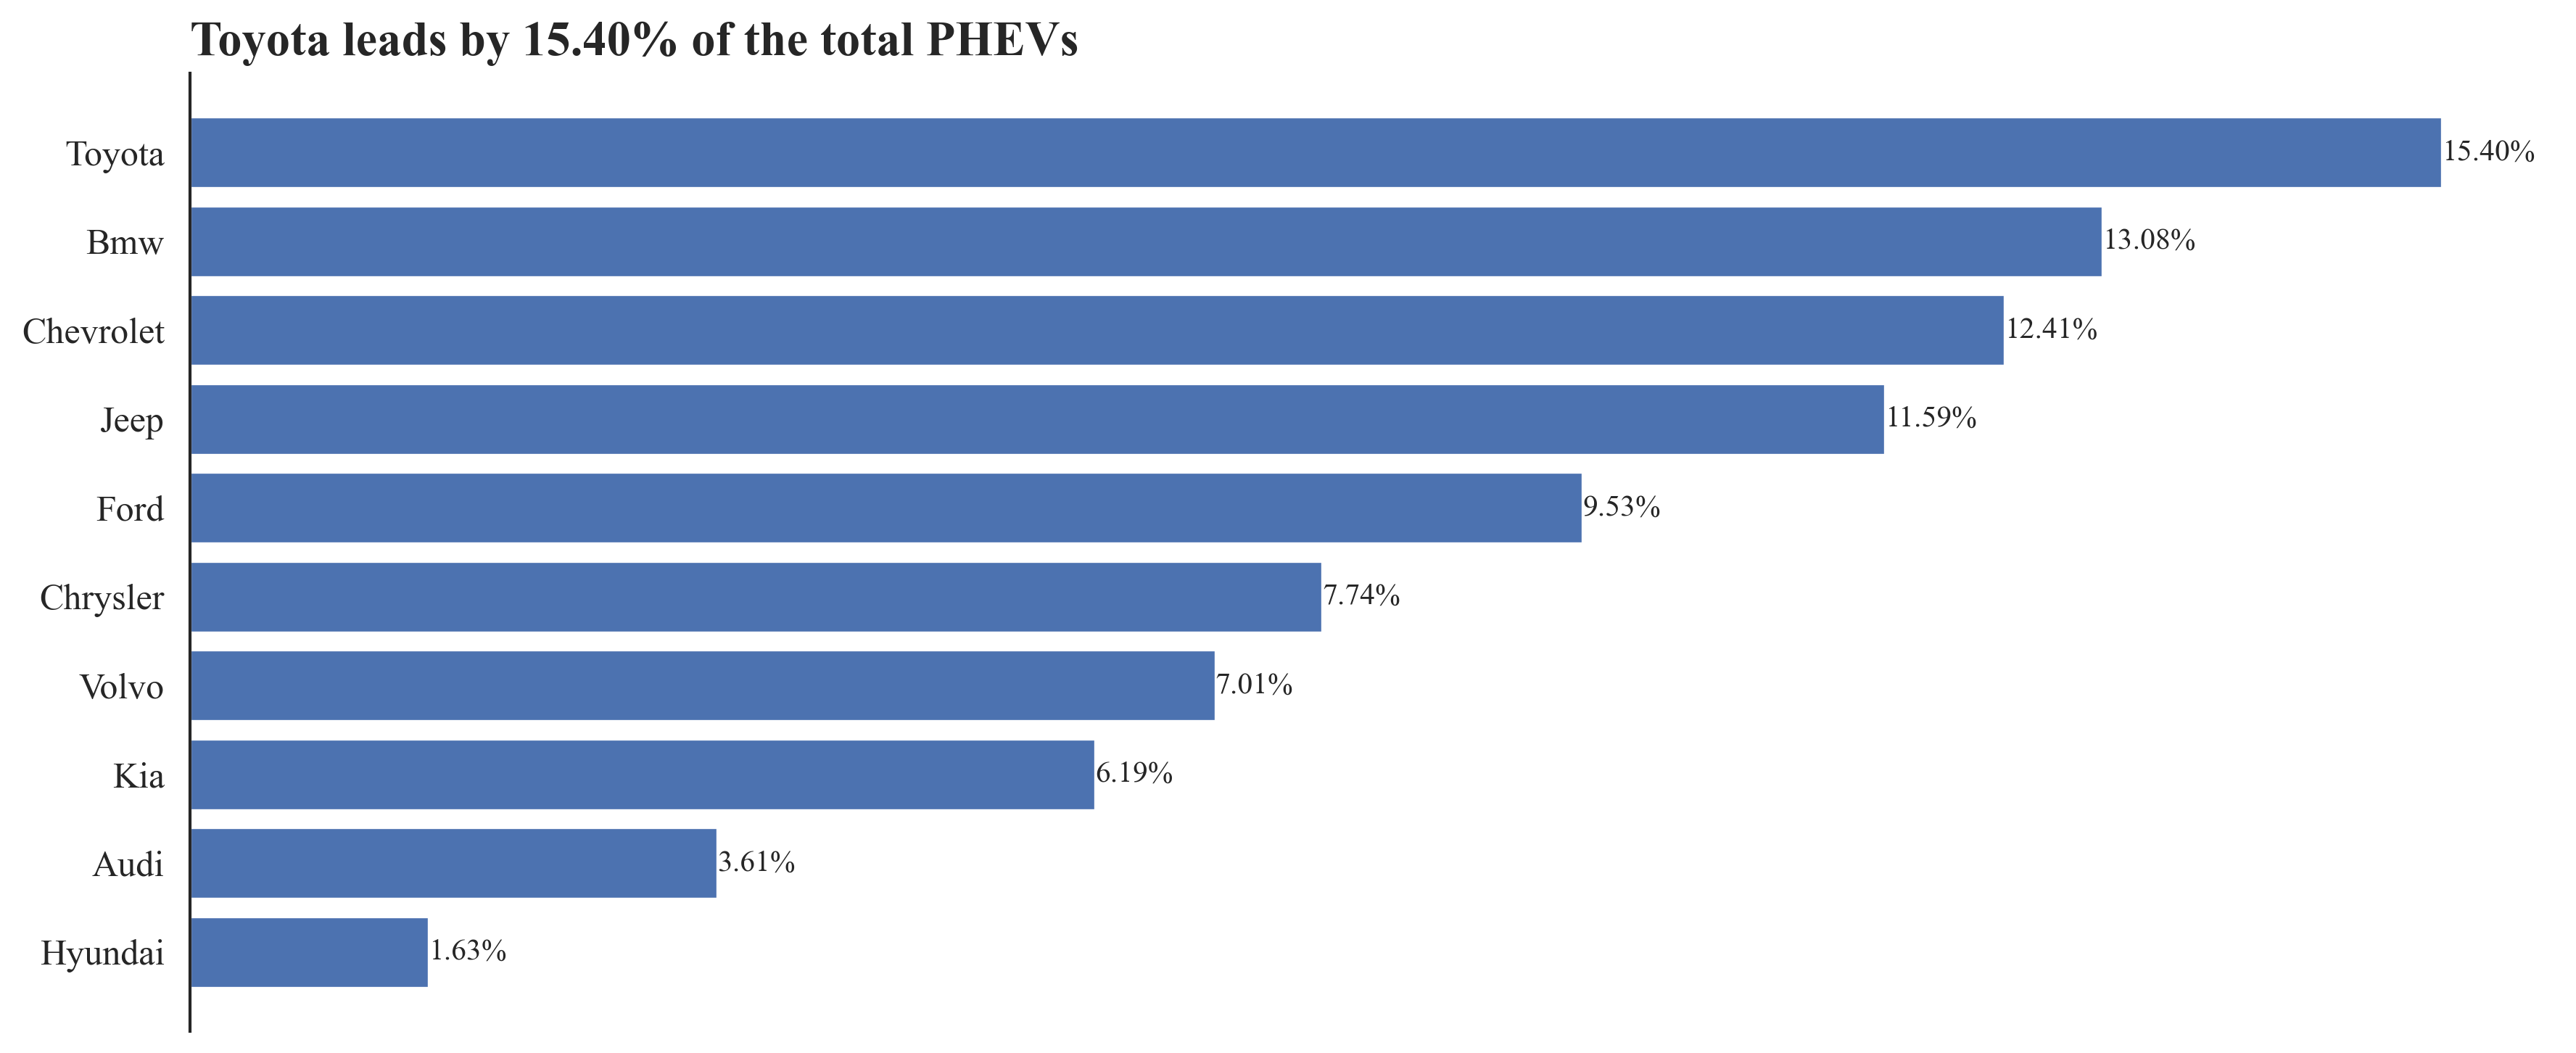

In [50]:
sorted_indices = sorted(range(len(phev_make_size['phev_pct_total'].head(10))), key=lambda i: phev_make_size['phev_pct_total'].iloc[i], reverse=False)
sorted_make = [phev_make_size.index[i] for i in sorted_indices]
sorted_size = [phev_make_size['phev_pct_total'].iloc[i] for i in sorted_indices]

fig, ax = plt.subplots()

ax.barh(sorted_make, sorted_size)

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Toyota leads by 15.40% of the total PHEVs', 
                loc='left', fontweight='bold')
ax.spines['bottom'].set_visible(False)
ax.tick_params(bottom=False, labelbottom=False)

for i, volume in enumerate(sorted_size):
    ax.text(volume, i, f"{volume:,.2f}%", va="center", fontsize=10)
plt.tight_layout();


## **What is the overall range distribution of EVs and which make offers the longest range per charge?**

In [51]:
electric_range_query = """
    SELECT
        dol_vehicle_id,
        AVG(range) AS range
    FROM
        vehicles
    GROUP BY
        dol_vehicle_id
"""

electric_range = (pd.read_sql_query(electric_range_query, connection)
                  .assign(z_score_range = lambda x: stats.zscore(x.range).abs())
                  .query('z_score_range <= 3 and range != 0')
                  )
electric_range


,dol_vehicle_id,range,z_score_range
0,4385,21.00,0.41
1,4777,200.00,1.53
2,10286,75.00,0.18
3,10734,75.00,0.18
4,12050,38.00,0.23
...,...,...,...
177861,478926346,25.00,0.37
177862,478934571,289.00,2.50
177863,478935460,75.00,0.18
177864,479114996,220.00,1.75


In [52]:
electric_range[['range']].describe().T


,count,mean,std,min,25%,50%,75%,max
range,"85,840.00",121.63,99.05,6.00,32.00,84.00,215.00,330.00


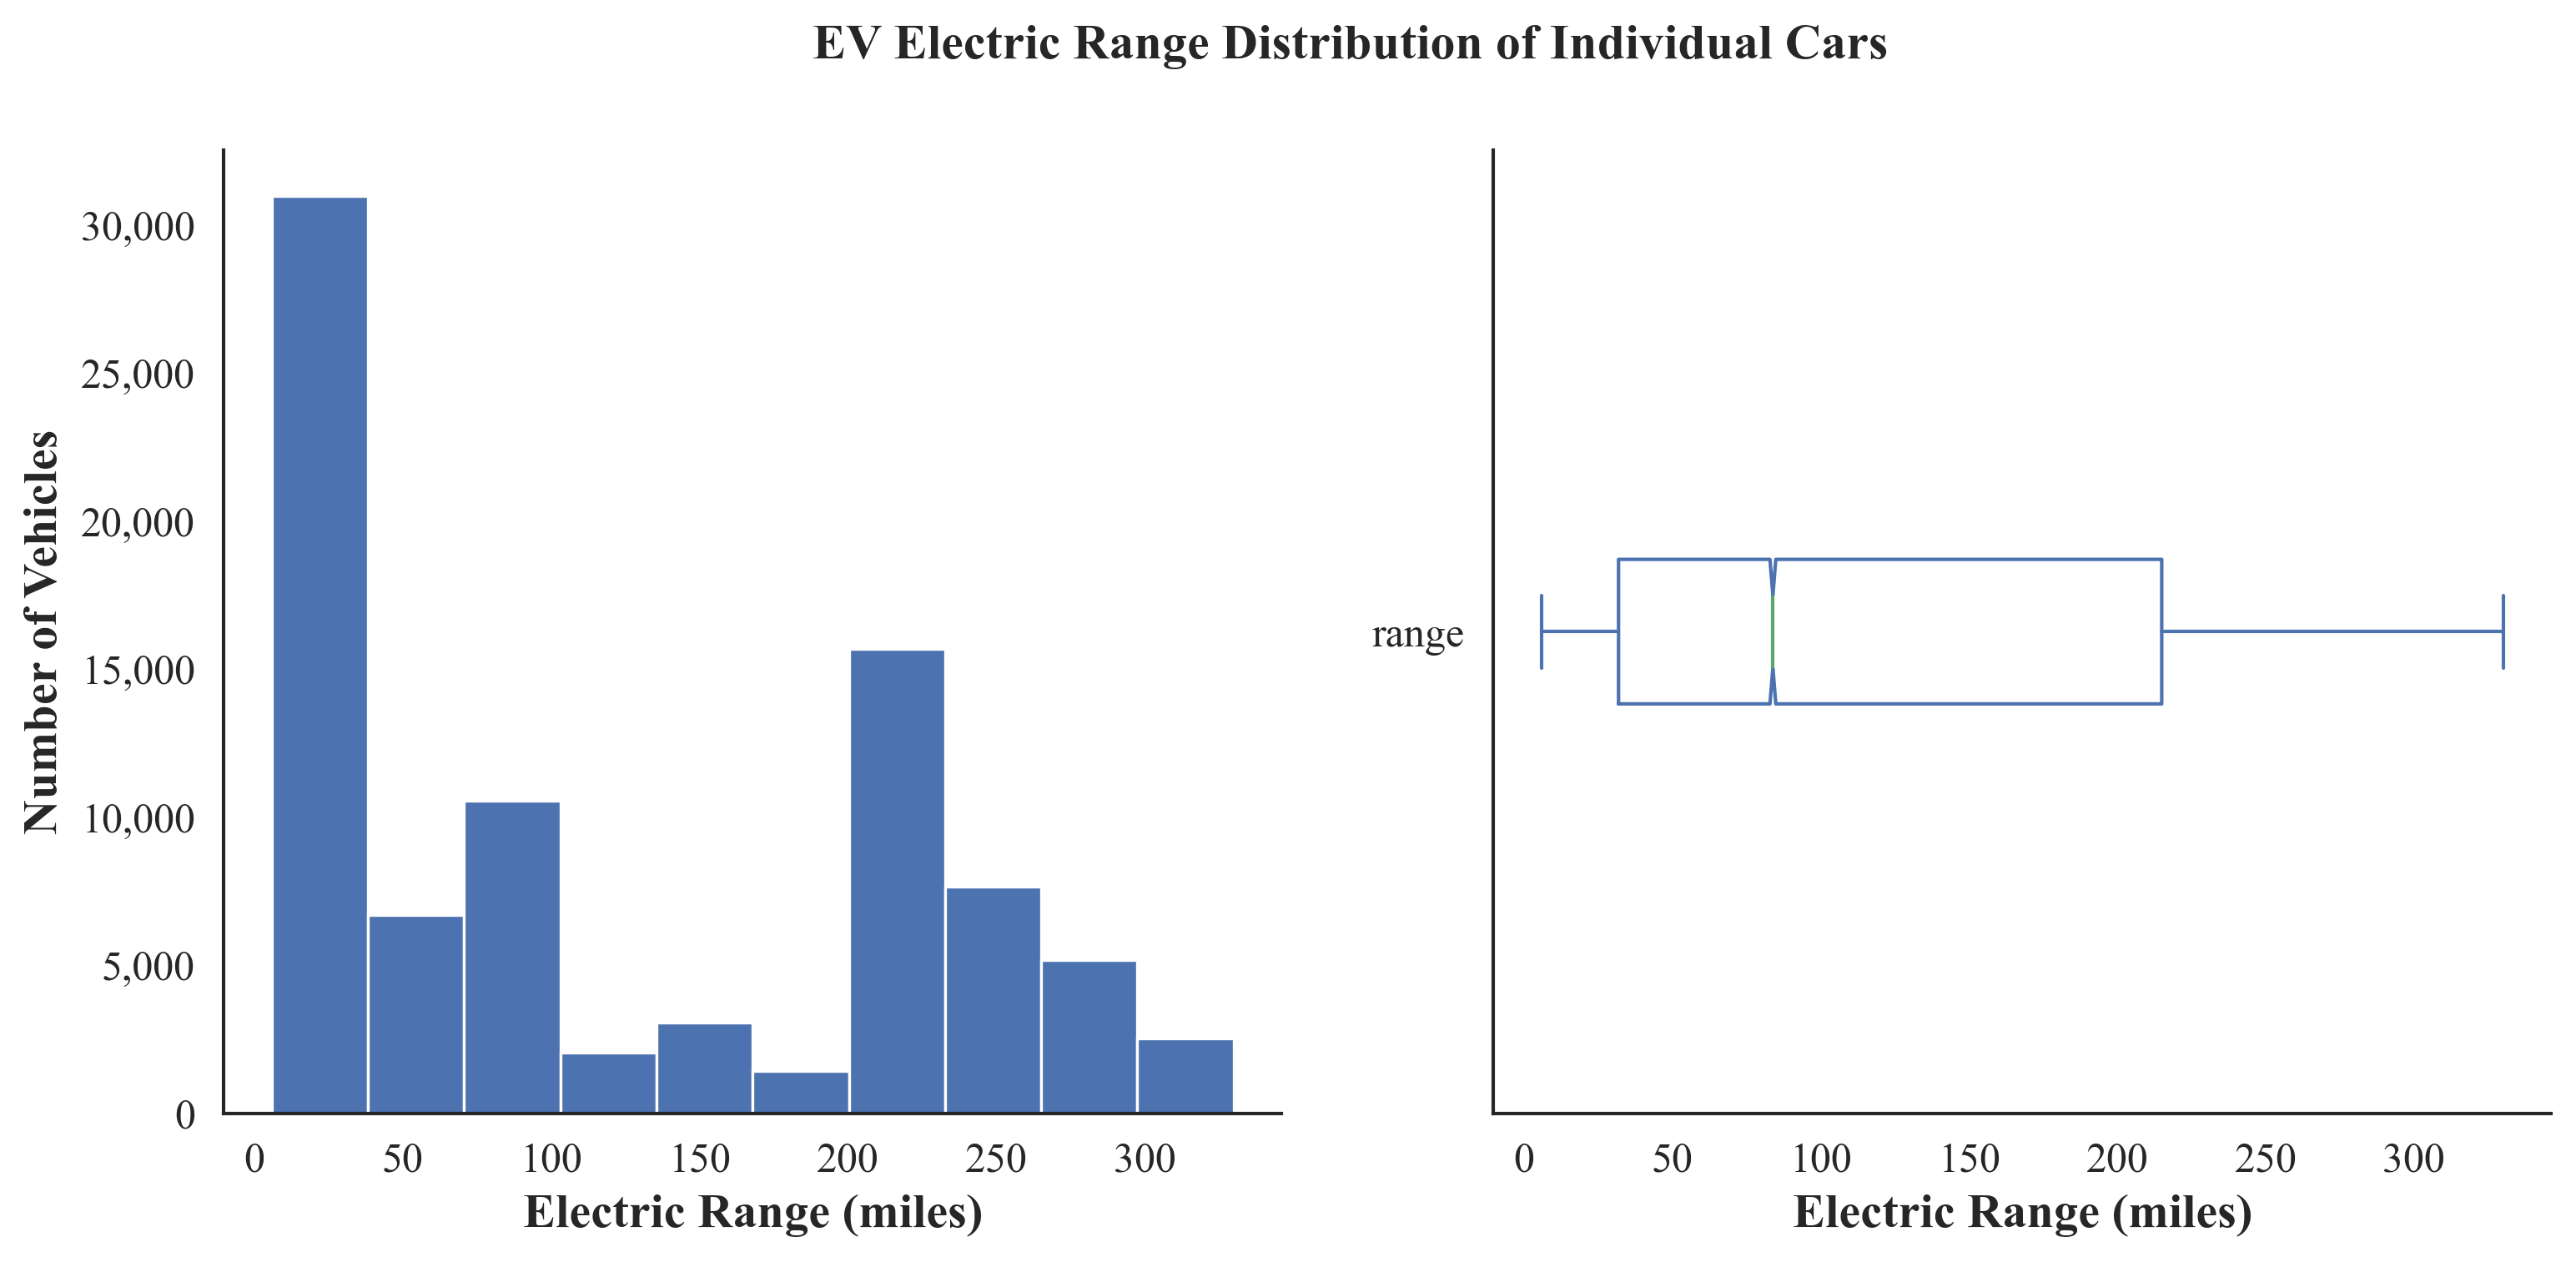

In [53]:
fig, (ax_hist, ax_box) = plt.subplots(1,2)
fig.suptitle('EV Electric Range Distribution of Individual Cars', 
             fontweight='bold')
electric_range.range.plot(kind='hist', ax=ax_hist)
electric_range.range.plot(kind='box', ax=ax_box, notch=True, vert=False)
ax_hist.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax_box.set_xlabel('Electric Range (miles)', loc='center', fontweight='bold')
ax_hist.set_ylabel('Number of Vehicles', loc='center', fontweight='bold')
ax_hist.set_xlabel('Electric Range (miles)', loc='center', fontweight='bold');


In [54]:
longest_range_electric_vehicles_bev_query = """
    SELECT 
        make,
        ROUND(AVG(range),2) AS electric_range_average
    FROM
        vehicles
    WHERE
        ev_type LIKE '%Battery%'
        AND
        range > 0
    GROUP BY 
        make
    ORDER BY
        electric_range_average DESC
"""

bev_range = pd.read_sql_query(longest_range_electric_vehicles_bev_query,connection)
bev_range = (bev_range
             .assign(make = bev_range.make.str.title())
             )
bev_range


,make,electric_range_average
0,Tesla,240.82
1,Chevrolet,235.81
2,Jaguar,234.00
3,Polestar,233.00
4,Hyundai,227.13
5,Audi,209.12
6,Porsche,198.42
7,Kia,178.22
8,Mini,110.00
9,Volkswagen,107.52


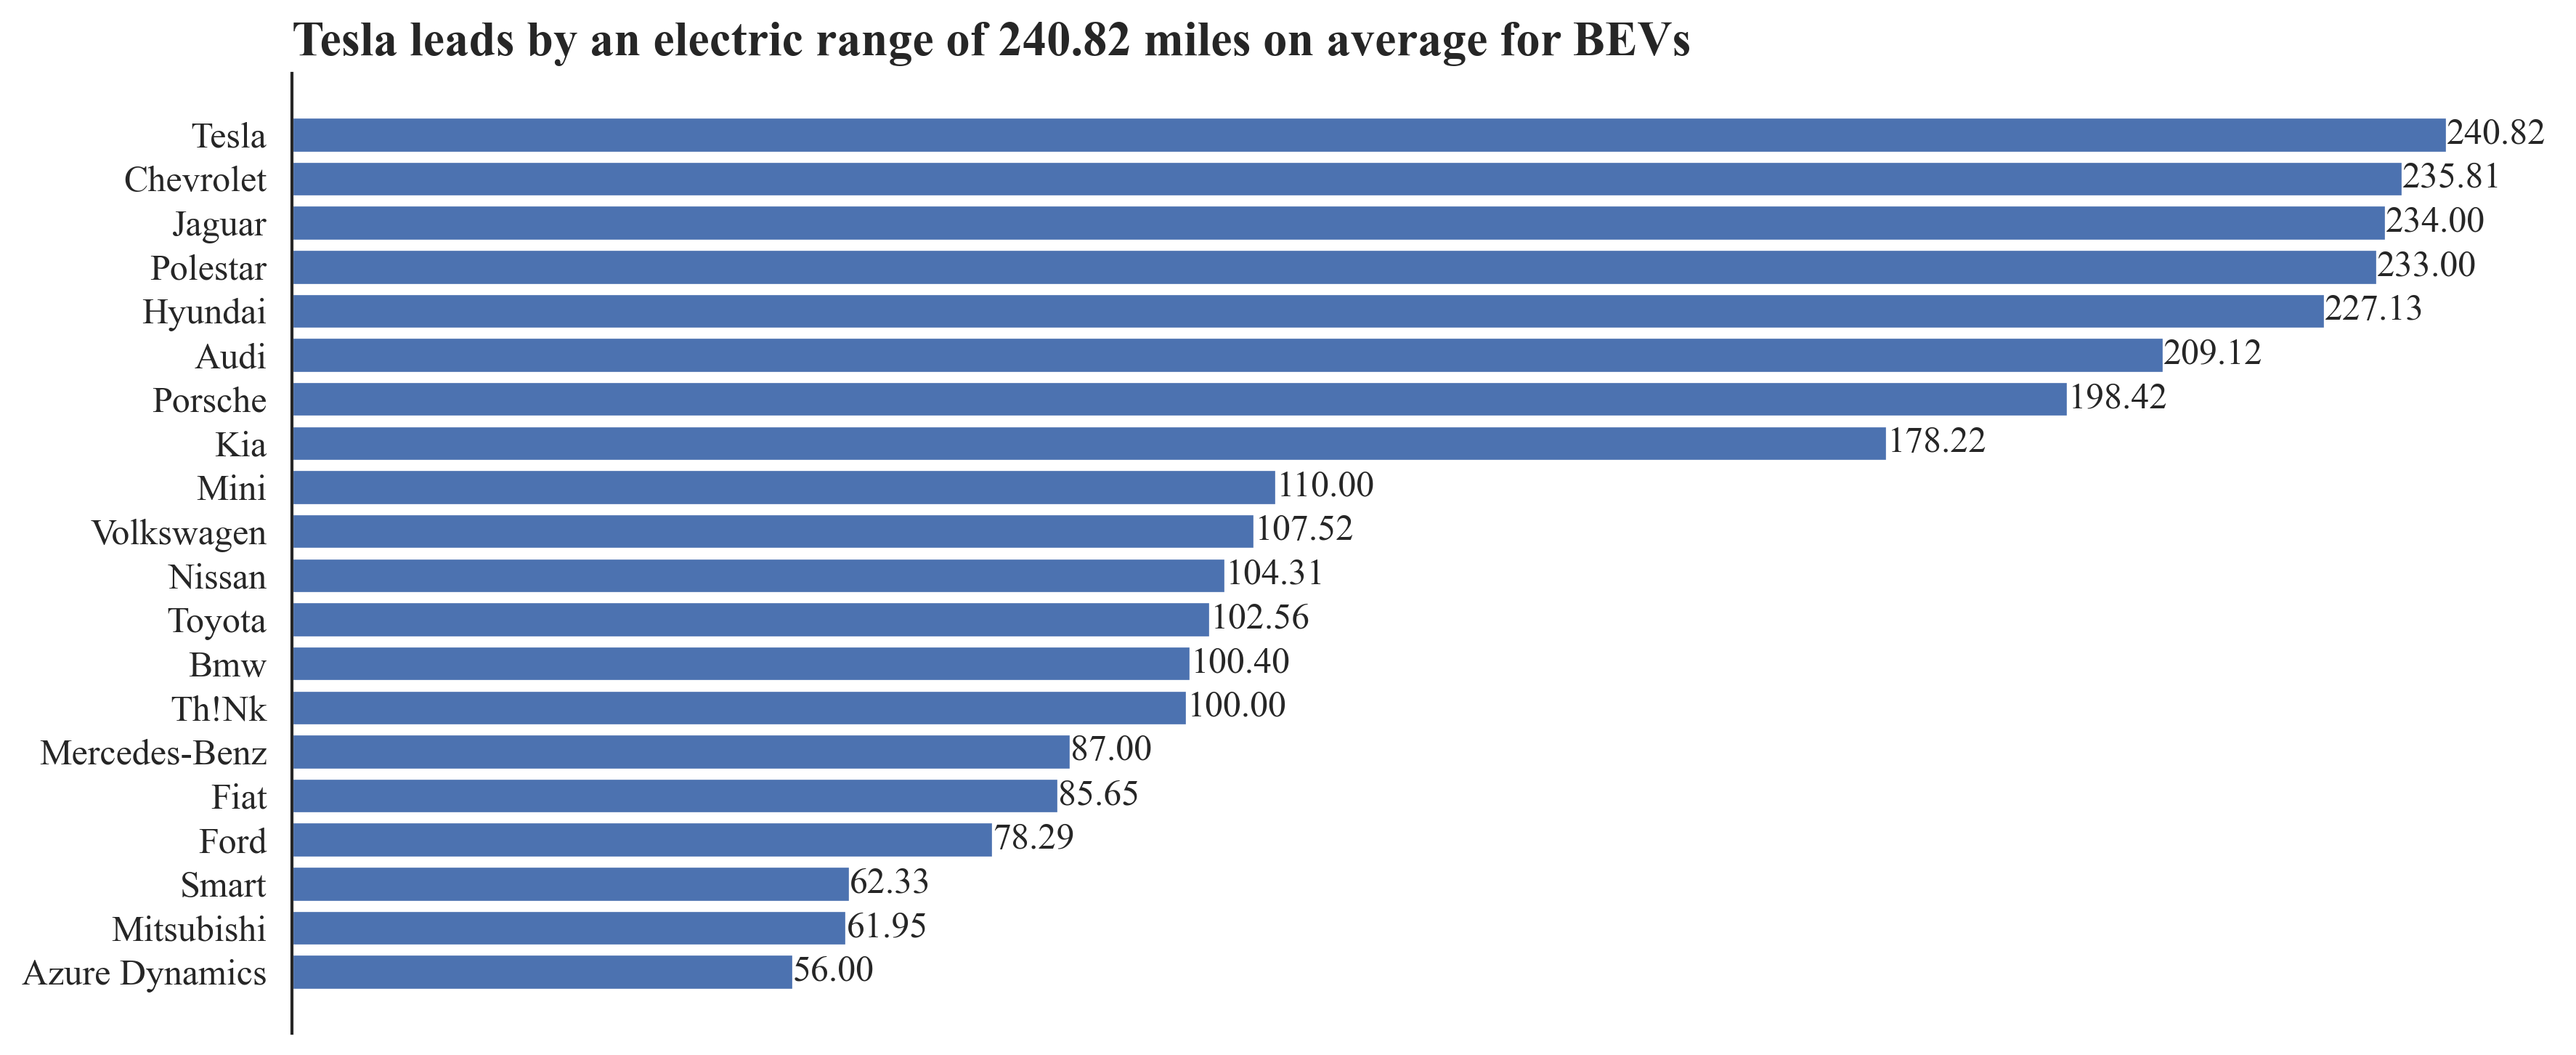

In [55]:
bev_range = bev_range.sort_values(by='electric_range_average', ascending=True)
fig, ax = plt.subplots()
ax.barh(bev_range['make'], bev_range['electric_range_average'])

ax.set_title('Tesla leads by an electric range of 240.82 miles on average for BEVs ', loc='left', fontweight='bold')
ax.spines['bottom'].set_visible(False)
ax.tick_params(bottom=False, labelbottom=False)
for i, volume in enumerate(bev_range['electric_range_average']):
    ax.text(volume, i, f"{volume:,.2f}", va="center", fontsize=12)

plt.tight_layout();


In [56]:
longest_range_electric_vehicles_bev_query = """
    SELECT 
        make,
        COUNT(*) AS total_vehicles,
        ROUND(AVG(range),2) AS electric_range_average
    FROM
        vehicles
    WHERE
        ev_type LIKE '%Plug-In%'
        AND
        range > 0
    GROUP BY 
        make
    ORDER BY
        electric_range_average DESC
"""

phev_range = pd.read_sql_query(longest_range_electric_vehicles_bev_query,connection)
phev_range = (phev_range
             .assign(make = phev_range.make.str.title())
             )
phev_range


,make,total_vehicles,electric_range_average
0,Wheego Electric Cars,3,100.00
1,Honda,833,46.60
2,Chevrolet,4796,45.36
3,Bmw,5055,40.89
4,Lexus,188,37.00
5,Cadillac,92,36.53
6,Fisker,13,33.00
7,Alfa Romeo,39,33.00
8,Chrysler,2993,32.21
9,Dodge,568,32.00


### **PHEV range**

The decision to only plot makes that have more than 100 cars was made based on the fact that few vehicles by certain makes would result to anomalous values of average electric range.

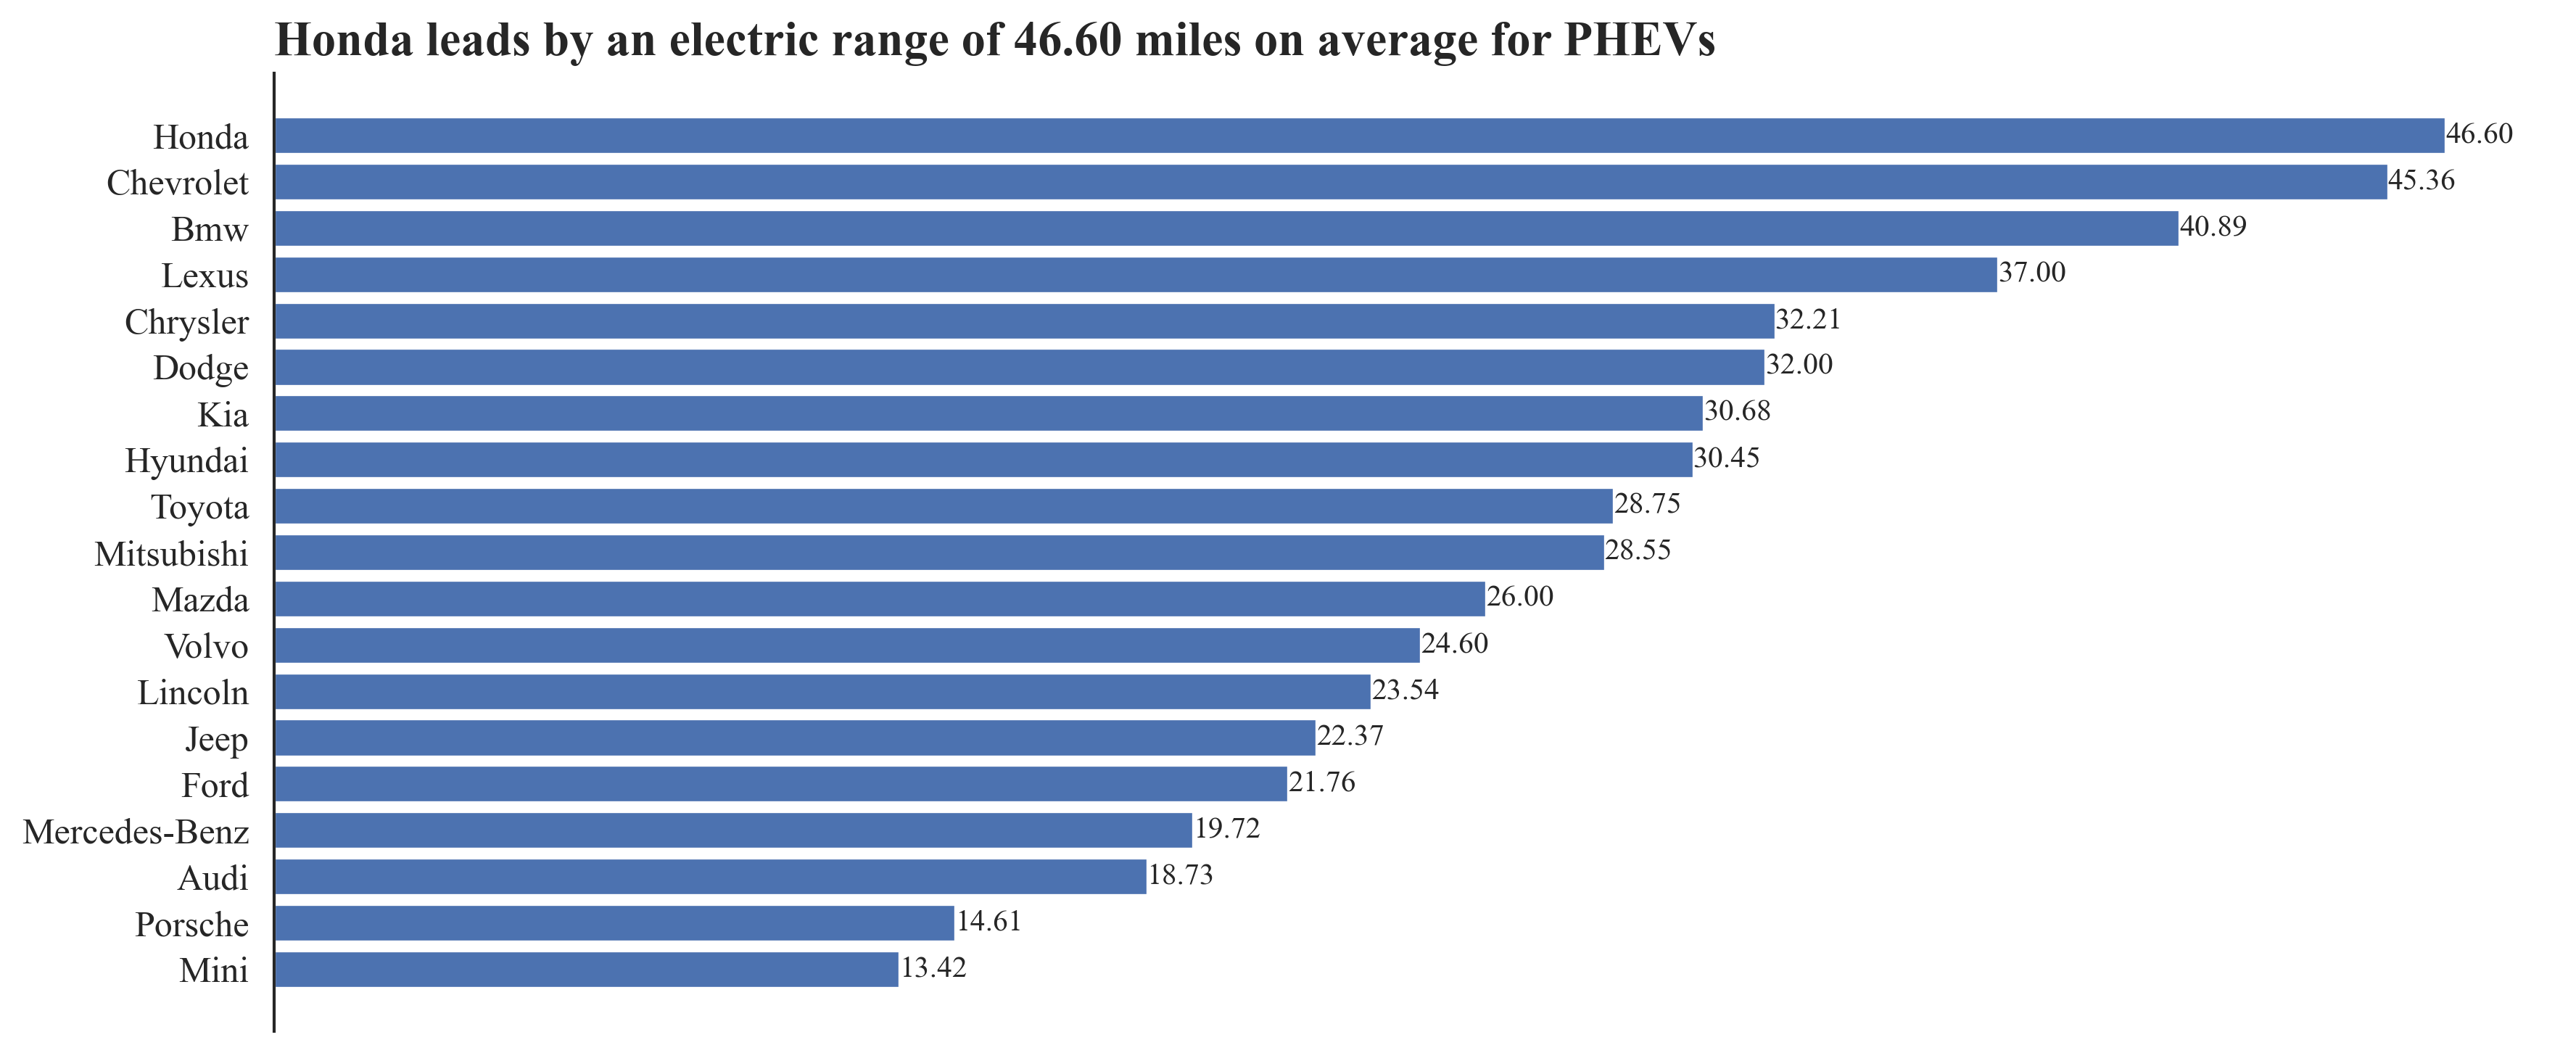

In [57]:
phev_range = phev_range[phev_range['total_vehicles']>=100].sort_values(by='electric_range_average', ascending=True)
fig, ax = plt.subplots()
ax.barh(phev_range['make'], phev_range['electric_range_average'])

ax.set_title('Honda leads by an electric range of 46.60 miles on average for PHEVs', loc='left', fontweight='bold')
ax.spines['bottom'].set_visible(False)
ax.tick_params(bottom=False, labelbottom=False)
for i, volume in enumerate(phev_range['electric_range_average']):
    ax.text(volume, i, f"{volume:,.2f}", va="center", fontsize=10)

plt.tight_layout();


## **How many Vehicles are eligible to be classified as Clean Alternative Fuel Vehicle**

In [58]:
clean_energy_eligibility_query = """ 
    SELECT
        cafv_eligibility AS cafv_eligibility,
        COUNT(DISTINCT dol_vehicle_id) AS vehicles
    FROM
        vehicles
    GROUP BY
        cafv_eligibility
    """
eligibility = (pd.read_sql_query(clean_energy_eligibility_query, connection)
               .assign(pct_total = lambda x: (x.vehicles / x.vehicles.sum())*100)
               )
eligibility


,cafv_eligibility,vehicles,pct_total
0,Clean Alternative Fuel Vehicle Eligible,66331,37.29
1,Eligibility unknown as battery range has not b...,91950,51.70
2,Not eligible due to low battery range,19585,11.01


In [59]:
eligibility_summary = pd.DataFrame({'eligibility': ['eligible','unknown','not_eligible'],
                                 'pct_total': [37.29,51.70,11.01]
                                 }
                                ).set_index('eligibility')
eligibility_summary


,pct_total
eligibility,
eligible,37.29
unknown,51.70
not_eligible,11.01


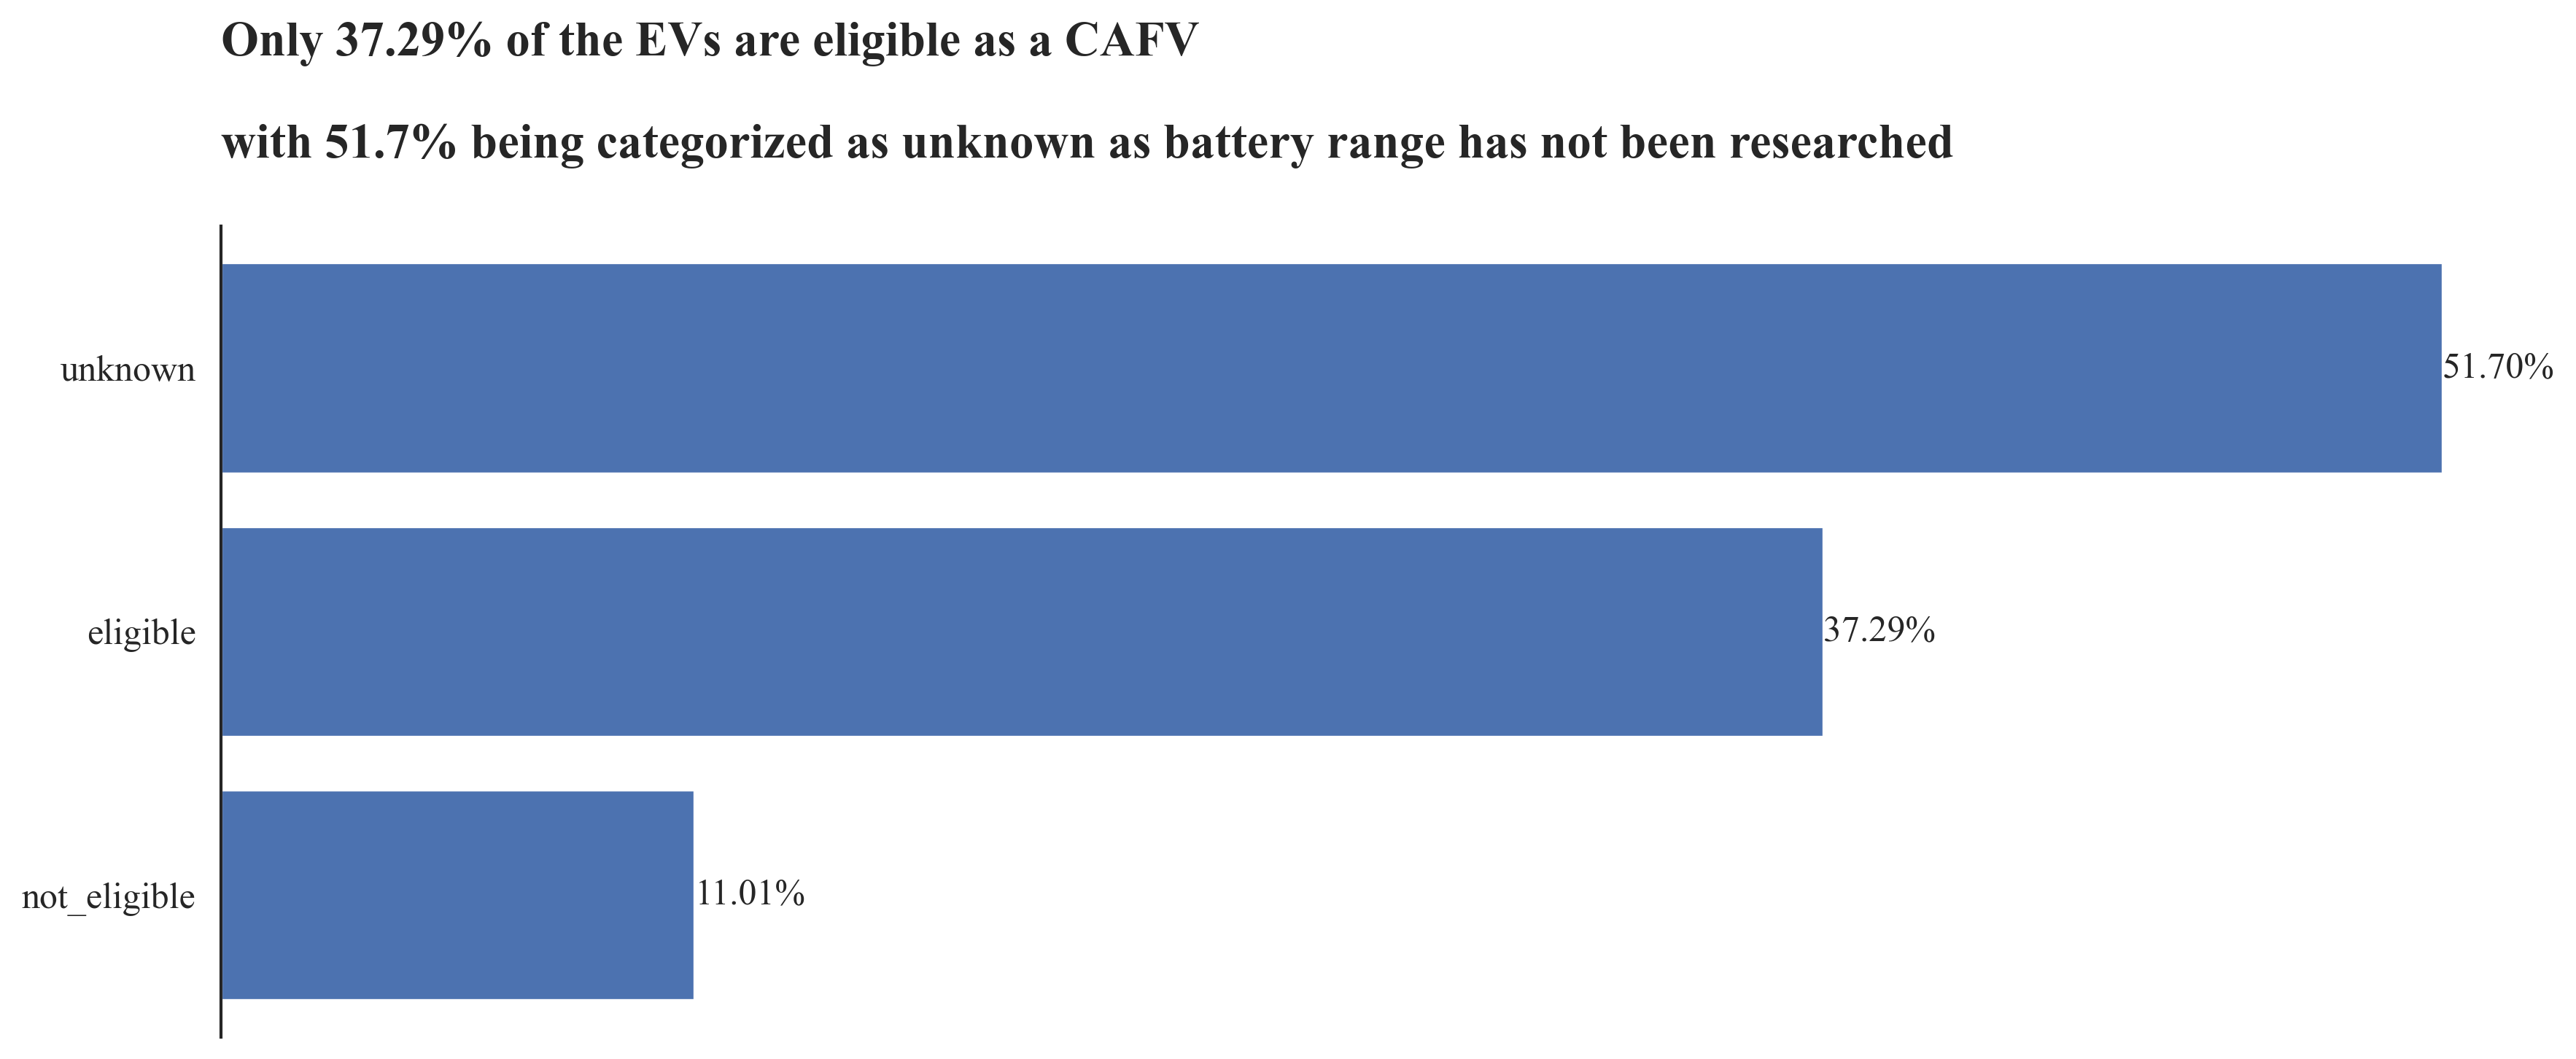

In [60]:
sorted_indices = sorted(range(len(eligibility_summary['pct_total'])), key=lambda i: eligibility_summary['pct_total'].iloc[i], reverse=False)
sorted_make = [eligibility_summary.index[i] for i in sorted_indices]
sorted_size = [eligibility_summary['pct_total'].iloc[i] for i in sorted_indices]

fig, ax = plt.subplots()

ax.barh(sorted_make, sorted_size)

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Only 37.29% of the EVs are eligible as a CAFV\n'
             '\nwith 51.7% being categorized as unknown as battery range has not been researched\n', 
             loc='left', fontweight='bold')
ax.spines['bottom'].set_visible(False)
ax.tick_params(bottom=False, labelbottom=False)

for i, volume in enumerate(sorted_size):
    ax.text(volume, i, f"{volume:,.2f}%", va="center", fontsize=12)
plt.tight_layout();


## **How many electric Utility Companies are there in WA and which one is most popular?**

In [61]:
total_electric_utility_query = """
    SELECT
        COUNT(DISTINCT electric_utility_0) AS utility_companies
    FROM
        charging_stations
"""
total_electric_utility = pd.read_sql_query(total_electric_utility_query, connection)
total_electric_utility


,utility_companies
0,21


In [62]:
most_popular_electric_utility_query = """ 
    SELECT
        electric_utility_0 AS electric_utility,
        COUNT(DISTINCT dol_vehicle_id) AS vehicles_served
    FROM
        charging_stations
    GROUP BY
        electric_utility
    ORDER BY
        vehicles_served DESC
    -- LIMIT 5
"""
most_popular_electric_utility = pd.read_sql_query(most_popular_electric_utility_query, connection)
most_popular_electric_utility = (most_popular_electric_utility
                                 .assign(electric_utility = lambda x: x.electric_utility.str.title(),
                                         pct_total = lambda x: x.vehicles_served / x.vehicles_served.sum() * 100
                                         )
                                 )
most_popular_electric_utility


,electric_utility,vehicles_served,pct_total
0,Puget Sound Energy Inc,105880,59.53
1,Bonneville Power Administration,34296,19.28
2,City Of Seattle - (Wa),31382,17.64
3,Pacificorp,1306,0.73
4,Modern Electric Water Company,1127,0.63
5,Pud No 1 Of Chelan County,1047,0.59
6,Pud No 2 Of Grant County,561,0.32
7,Avista Corp,400,0.22
8,Non Washington State Electric Utility,384,0.22
9,Pud No 1 Of Douglas County,362,0.20
